# Automatic tagging 

- Multi-label classification

challenge is how to set the value of the threshold. Possibilities are:

Fixed threshold, e.g. Label is true if $y_{pred}^i &gt; 0.2$ <br>
Dynamic threshold, e.g. Label is true if $y_{pred}^i &gt; \frac{1}{4}\max(y_{pred})$

# 1)- Importing key modules

In [0]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [0]:
import os
import pickle as pkl
import re
import string

In [0]:
# for data processing

import numpy as np
import pandas as pd 
import tqdm

In [4]:
# for text 

import nltk
import re 
from nltk import tokenize
import nltk
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
lemm = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
# for analysis

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# For modeling

from sklearn import neighbors
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [0]:
# For visuals

import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
% matplotlib inline 
pd.set_option('display.max_colwidth', 200)

In [7]:
! pip install version_information

In [8]:
# first install: pip install version_information
%reload_ext version_information
%version_information pandas,numpy,sklearn,nltk, seaborn, matplotlib

Software versions
Python 3.6.8 64bit [GCC 8.3.0]
IPython 5.5.0
OS Linux 4.14.137+ x86_64 with Ubuntu 18.04 bionic
pandas 0.25.3
numpy 1.17.4
sklearn 0.21.3
nltk 3.2.5
seaborn 0.9.0
matplotlib 3.1.1
Thu Nov 28 16:05:33 2019 UTC

# 2)- Reading Dataset

Thanks to PyData 2018: Gilbert Francois Talk

In [9]:
data= pd.read_pickle('messages-cls-mc.pkl')
data.shape

(1719, 6)

In [10]:
data.head()

,ts,user,text,class,key,multiclass
0,1.503303e+09,Balaemar,I have to pick up my car from the garage tomorrow. I have to leave at 15:45 on Thursday.,1,1503303350U035FRUCY,"[1, 8]"
1,1.503302e+09,Ragaenys,"I won’t be here tomorrow, one day vacation",2,1503301710U4A2FRAQ4,[2]
2,1.503296e+09,Myke,"Missed connection in Zurich. Will be about 5-10 mins late in the office, so will miss the weekly today.",1,1503296123U0MGNKETU,[1]
3,1.503260e+09,Drevyn,Enjoy!,8,1503259722U035B8PRU,[8]
4,1.503258e+09,Gaelralis,I am away for 2 weeks in iceland :flag-is:,2,1503258060U0HLAK1T6,[2]


In [11]:
data.tail()

,ts,user,text,class,key,multiclass
1714,1.462269e+09,Overton,<@U0PSDKXHR|jabbah> has joined the channel,8,1462269461U0PSDKXHR,[8]
1715,1.462269e+09,Balaemar,<@U035FRUCY|miamia> has joined the channel,8,1462269461U035FRUCY,[8]
1716,1.462269e+09,Eliar,<@U0A8NPHRD|joe> has joined the channel,8,1462269366U0A8NPHRD,[8]
1717,1.462268e+09,Caenraenos,"<@U035AASB8|Fisher> set the channel topic: home office, lateness, general absence updates",8,1462267520U035AASB8,[8]
1718,1.462267e+09,Caenraenos,<@U035AASB8|Fisher> has joined the channel,8,1462267404U035AASB8,[8]


In [12]:
data['class'].unique()

array([1, 2, 8, 3, 6, 4, 5, 7])

# Class	Description
- 1	Too late, away during office hours or early leave
- 2	Holidays or scheduled free days
- 3	Home Office
 -4	Medical appointment
- 5	Ill, without consulting a medical
- 6	Work related absence (at client, conference)
- 7	In office announcement
- 8	Miscellanious

In [0]:
dict_classes = {
    1: 'late/early',
    2: 'holidays',
    3: 'home office',
    4: 'med app',
    5: 'ill',
    6: 'business',
    7: 'in office',
    8: 'miscellanious'
}

In [14]:
data['class'].value_counts()

1    517
3    423
8    223
2    173
6    142
4    134
5     74
7     33
Name: class, dtype: int64

But, our dependant variable is not class anymore. We are interested in exploring multi-label class.

In [0]:
df=data[['text','multiclass']]

In [16]:
type(df)

pandas.core.frame.DataFrame

In [17]:
df.head()

,text,multiclass
0,I have to pick up my car from the garage tomorrow. I have to leave at 15:45 on Thursday.,"[1, 8]"
1,"I won’t be here tomorrow, one day vacation",[2]
2,"Missed connection in Zurich. Will be about 5-10 mins late in the office, so will miss the weekly today.",[1]
3,Enjoy!,[8]
4,I am away for 2 weeks in iceland :flag-is:,[2]


In [0]:
# Remove all rows which have no annotation
df = df.dropna()

In [19]:
df.shape

(1719, 2)

### checking missing value if any

In [20]:
df.isnull().sum()

text          0
multiclass    0
dtype: int64

### Separating X and y

In [0]:
X = df['text']
y = df['multiclass']

# 3)- Making Helper Functions

In [0]:
lemm = WordNetLemmatizer()
stemmer = nltk.PorterStemmer()
analyzer = CountVectorizer().build_analyzer()

def lemma(doc):
    return [lemm.lemmatize(w) for w in analyzer(doc)]


def no_lemma(doc):
    return [w for w in analyzer(doc)]


def stemmed(doc):
    return [stemmer.stem(w) for w in analyzer(doc)]


def no_stemmed(doc):
    return [w for w in analyzer(doc)]


def mask_integers(text):
    return re.sub(r'\d+', '_NUMBER', text)


def mask_times(text):
    """
    Replaces times written like 12:50, 1PM, 4:15am, etc to _time token.
    :param    text    Input text
    :return           Output text with replaced times.
    """
    re_time1 = '\d{1,2}[:.]\d{2}(?:am|pm|AM|PM)'
    re_time2 = '\d{1,2}[:.]\d{2}'
    re_time3 = '\d{1,2}(?:am|pm|AM|PM)'
    rec_time = re.compile(re_time1 + '|' + re_time2 + '|' + re_time3)
    return re.sub(rec_time, '_TIME', text)


def mask_emojis(text):
    """
    Replaces all different emojis to _emoji token.
    :param    text    Input text
    :return           Output text with replaced emojis.    
    """
    re_icons = ':[a-z-_]*:'
    re_ldsd = '\<(.*?)\>'
    rec_icons = re.compile(re_icons + "|" + re_ldsd)
    return re.sub(rec_icons, '_EMOJI', text)


def mask_all(text):
    text = mask_times(text)
    text = mask_emojis(text)
    text = mask_integers(text)
    return text


def train_and_test(steps, X_train, X_test, y_train, y_test):
    """
    Trains and tests the pipeline with the given steps. 
    :param steps:       List of operations inside the pipeline.
    :param X_train:     Training data
    :param X_test:      Training labels
    :param y_train:     Testing data
    :param y_test:      Testing labels
    :return:            Trained model
    """
    pipeline = Pipeline(steps)
    folds = 10
    xval_score = cross_val_score(pipeline, X_train, y_train, cv=folds, n_jobs=-1)
    
    xv_min = np.min(xval_score)
    xv_max = np.max(xval_score)
    xv_mean = np.mean(xval_score)
    xv_std = np.std(xval_score)
    print('{} fold Cross Validation Score: <{:.2f}, {:.2f}>; µ={:.2f}'.format(folds, xv_min, xv_max, xv_mean))
    pipeline = pipeline.fit(X_train, y_train)
    print('Score on test set: {:.2f}'.format(pipeline.score(X_test, y_test)))
    return pipeline


def tag_message(pipeline, message):
    y_pred = pipeline.predict([message])[0]
    print('{:>20} | {}'.format(dict_classes[y_pred], message))
    

def multitag_message(pipeline, message):
    y_pred = pipeline.predict([message])[0]
    tags = [dict_classes[i+1] for i, yi in enumerate(y_pred) if yi == 1]
    # Remove `misc` tag if the list contains other tags as well.
    if len(tags) > 1 and dict_classes[8] in tags:
        del tags[tags.index(dict_classes[8])]
    print('{:>30} | {}'.format('['+'] ['.join(tags)+']', message))


  

# 4)- Data Preprocessing

In [23]:
X[:5]

0                   I have to pick up my car from the garage tomorrow. I have to leave at 15:45 on Thursday.
1                                                                 I won’t be here tomorrow, one day vacation
2    Missed connection in Zurich. Will be about 5-10 mins late in the office, so will miss the weekly today.
3                                                                                                     Enjoy!
4                                                                 I am away for 2 weeks in iceland :flag-is:
Name: text, dtype: object

In [24]:
y[:5]

0    [1, 8]
1       [2]
2       [1]
3       [8]
4       [2]
Name: multiclass, dtype: object

In [25]:
# Convert the categorical class vectors to binary vectors with MultiLabelBinarizer
ym = MultiLabelBinarizer().fit_transform(y)
print(ym.shape)
ym[:5]

(1719, 8)


array([[1, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 0]])

### 4a)- Train-Test Split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, ym, test_size=0.20, random_state=1)

In [27]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1375,)
(344,)
(1375, 8)
(344, 8)


# 5)- Buidling NLP pipeline

https://buhrmann.github.io/sklearn-pipelines.html

In [28]:
steps = [('vectorizer', CountVectorizer(ngram_range=(1,2), 
                                        preprocessor=mask_all, 
                                        analyzer=stemmed, 
                                        stop_words='english')),
         ('transformer', TfidfTransformer()),
         ('classifier', OneVsRestClassifier(SVC(kernel='linear')))]
pipeline1 = train_and_test(steps, X_train, X_test, y_train, y_test)

10 fold Cross Validation Score: <0.51, 0.69>; µ=0.59
Score on test set: 0.62


In [0]:
# predicted value
y_pred_list = pipeline1.predict(X_test).tolist()

In [0]:
# true value
y_test_list = y_test.tolist()

In [31]:
for index in range(len(y_pred_list))[:10]:
    if y_pred_list[index] != y_test_list[index]:
        print('[pred]: ', y_pred_list[index])
        print('[true]: ', y_test_list[index])
        print('[doc ]: ', X_test.iloc[index])
        print()

[pred]:  [0, 0, 1, 0, 0, 0, 0, 0]
[true]:  [0, 0, 1, 0, 0, 0, 0, 1]
[doc ]:  I just get the confirmation for my appointment on monday. I will be off in the morning and in HO after lunch time.

[pred]:  [1, 0, 0, 0, 0, 0, 0, 0]
[true]:  [0, 1, 0, 0, 0, 0, 0, 0]
[doc ]:  I will be away from the 25th to the 3rd of December.

[pred]:  [1, 0, 1, 0, 0, 0, 0, 1]
[true]:  [0, 0, 1, 0, 0, 0, 1, 1]
[doc ]:  I do HO in the morning. We are expecting a phone call from the real estate agent around 12:00-13:00. I come to the office after the call. Sorry for the late announcement.

[pred]:  [1, 0, 0, 0, 0, 0, 0, 0]
[true]:  [1, 0, 0, 0, 0, 0, 0, 1]
[doc ]:  Tomorrow I’ll have to head out for a while, our stuff will arrive from Hungary. Don’t know exactly when, the transporter will call. They estimated it around noon.

[pred]:  [0, 0, 1, 1, 0, 0, 0, 0]
[true]:  [0, 0, 0, 1, 0, 0, 0, 0]
[doc ]:  My wife has a doctors appointment today afternoon so i will be in home office after lunch



### testing on out of sample data

In [32]:
multitag_message(pipeline1, 'I don\'t feel well, stay home and don\'t come to the office.')
multitag_message(pipeline1, 'My alarm clock was not set properly. I come to the office asap.')
multitag_message(pipeline1, 'It is my scheduled day off, see you on Tuesday.')
multitag_message(pipeline1, 'I\'m having a terrible headache, I stay home and work from here.')
multitag_message(pipeline1, 'I work at home on Tuesday.')
multitag_message(pipeline1, 'In the morning I\'ve a meeting with IBM, I\'ll be back at 1pm.')
multitag_message(pipeline1, 'I\'m off, see you tomorrow.')
multitag_message(pipeline1, 'get well soon!')
multitag_message(pipeline1, 'I\'m away for a long lunch between 12:00 and 15:30')
multitag_message(pipeline1, 'I\'ve an appointment at 12:00 at the physiotherapy.')
multitag_message(pipeline1, 'I go to the doctor and will be online again after 18:00.')

                         [ill] | I don't feel well, stay home and don't come to the office.
                  [late/early] | My alarm clock was not set properly. I come to the office asap.
        [holidays] [in office] | It is my scheduled day off, see you on Tuesday.
           [home office] [ill] | I'm having a terrible headache, I stay home and work from here.
                 [home office] | I work at home on Tuesday.
        [business] [in office] | In the morning I've a meeting with IBM, I'll be back at 1pm.
        [holidays] [in office] | I'm off, see you tomorrow.
               [miscellanious] | get well soon!
                  [late/early] | I'm away for a long lunch between 12:00 and 15:30
                     [med app] | I've an appointment at 12:00 at the physiotherapy.
       [home office] [med app] | I go to the doctor and will be online again after 18:00.


# 6)-Multi label predictions with sentence tokenization

We will use part of speech (POS) tagging to analyse the sentence and see if it can be splitted or not.

-Key assumption:

- A document has only multiple class labels when it has multiple sentences.
- Every sentence contains only one class label.

### a)-Helper Function

In [0]:
def sentence_tokenizer(text, verbose=False):
    # Some input checking.
    if not isinstance(text, str):
        print('[!] Input type should be a string, not a {}'.format(type(text)))
        exit(1)
        
    # Split sentences with NLTK
    text_list_1 = nltk.sent_tokenize(text)
    
    # Split sentences with our POS tagging method
    text_list_2 = []
    for text in text_list_1:
        text_list_2 += custom_sentence_tokenizer(text, verbose)
    
    return text_list_2


def custom_sentence_tokenizer(text, verbose=False):
    # container for final result
    new_split = []
    
    # Split sentences by a comma, 'and' and 'or'.
    text_list = re.split(',| and | or | but | \(', text)
    
    # Remove white spaces and empty string elements from the list
    text_list = [x.strip() for x in text_list]
    text_list = list(filter(None, text_list))
        
    # Append first list element to the new list.
    new_split.append(text_list[0])
    
    # Check if the splits are valid sentences. If not, glue the parts together again.
    for index in range(1, len(text_list)):
        
        # Keep the split if both parts of the sentences contain a verb.
        if has_verb(text_list[index-1], verbose) and has_verb(text_list[index], verbose):
            new_split.append(text_list[index])
        # Glue the parts together again, since POS requirements are not met.
        else:
            new_split[-1] += ' ' + text_list[index]
    
    if verbose:
        print('[.] Input sentence:')
        print('    ', text)
        print('[.] Output sentence(s):')
        print('    ', new_split)
    return new_split
    

def has_verb(sentence, verbose=False):
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    if verbose:
        print(pos_tagged)
    if 'VB' in [tag[1][:2] for tag in pos_tagged]:
        return True
    return False


def split_sentences_in_dataframe(df, verbose=False):
    new_df = pd.DataFrame()
    for index, row in df.iterrows():
        text = row['text']
        text_list = sentence_tokenizer(text, verbose)
        for text_part in text_list:
            new_row = row.copy()
            new_row['text'] = text_part
            new_df = new_df.append(new_row)
    return new_df

### b)- Example

In [34]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [0]:
doc1 = "I'm afraid I can't explain myself, sir. Because I am not myself, you see?"
doc2 = "I have to leave around 11am, having a meeting with alice and will be back after 15:00."

In [36]:
nltk.sent_tokenize(doc1)

["I'm afraid I can't explain myself, sir.",
 'Because I am not myself, you see?']

In [37]:
sentence_tokenizer(doc1, True)

[('I', 'PRP'), ("'m", 'VBP'), ('afraid', 'JJ'), ('I', 'PRP'), ('ca', 'MD'), ("n't", 'RB'), ('explain', 'VB'), ('myself', 'PRP')]
[('sir', 'NN'), ('.', '.')]
[.] Input sentence:
     I'm afraid I can't explain myself, sir.
[.] Output sentence(s):
     ["I'm afraid I can't explain myself sir."]
[('Because', 'IN'), ('I', 'PRP'), ('am', 'VBP'), ('not', 'RB'), ('myself', 'PRP')]
[('you', 'PRP'), ('see', 'VBP'), ('?', '.')]
[.] Input sentence:
     Because I am not myself, you see?
[.] Output sentence(s):
     ['Because I am not myself', 'you see?']


["I'm afraid I can't explain myself sir.",
 'Because I am not myself',
 'you see?']

In [38]:
nltk.sent_tokenize(doc2)

['I have to leave around 11am, having a meeting with alice and will be back after 15:00.']

In [39]:
sentence_tokenizer(doc2, True)

[('I', 'PRP'), ('have', 'VBP'), ('to', 'TO'), ('leave', 'VB'), ('around', 'RP'), ('11am', 'CD')]
[('having', 'VBG'), ('a', 'DT'), ('meeting', 'NN'), ('with', 'IN'), ('alice', 'NN')]
[('having', 'VBG'), ('a', 'DT'), ('meeting', 'NN'), ('with', 'IN'), ('alice', 'NN')]
[('will', 'MD'), ('be', 'VB'), ('back', 'RB'), ('after', 'IN'), ('15:00', 'CD'), ('.', '.')]
[.] Input sentence:
     I have to leave around 11am, having a meeting with alice and will be back after 15:00.
[.] Output sentence(s):
     ['I have to leave around 11am', 'having a meeting with alice', 'will be back after 15:00.']


['I have to leave around 11am',
 'having a meeting with alice',
 'will be back after 15:00.']

### c)- Back to dataset

In [40]:
df_messages = pd.read_pickle('messages-cls-ms.pkl')
df_messages.head(10)

,user,class,text,ts,key
0,Balaemar,8,I have to pick up my car from the garage tomorrow.,1.503303e+09,1503303350U035FRUCY
0,Balaemar,1,I have to leave at 15:45 on Thursday.,1.503303e+09,1503303350U035FRUCY
1,Ragaenys,2,I won’t be here tomorrow one day vacation,1.503302e+09,1503301710U4A2FRAQ4
2,Myke,1,Missed connection in Zurich.,1.503296e+09,1503296123U0MGNKETU
2,Myke,1,Will be about 5-10 mins late in the office,1.503296e+09,1503296123U0MGNKETU
2,Myke,1,so will miss the weekly today.,1.503296e+09,1503296123U0MGNKETU
3,Drevyn,8,Enjoy!,1.503260e+09,1503259722U035B8PRU
4,Gaelralis,2,I am away for 2 weeks in iceland :flag-is:,1.503258e+09,1503258060U0HLAK1T6
5,Gonaleos,8,Monday is the first day in school for my son,1.503223e+09,1503222795U3W886EF4
5,Gonaleos,8,I am going to go there with him,1.503223e+09,1503222795U3W886EF4


So , first data has been tagged and tokenized into separated sentences with one class representing each sentence. Then annotation is done. And hence, data is ready to be analysed .

In [41]:
# Convert the class column to int, it might be stored as a string
df_messages['class'] = df_messages.loc[:, 'class'].astype(np.uint8).values
print('Number of documents: {}'.format(len(df_messages)))

Number of documents: 3105


In [0]:
X=df_messages['text']
y=df_messages['class']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=1)

In [44]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2484,)
(621,)
(2484,)
(621,)


# 7)- Building Pipelines

In [45]:
teps = [('vectorizer', CountVectorizer(analyzer=stemmed,
                                        ngram_range=(1,2),
                                        stop_words='english',
                                        preprocessor=mask_all)),
         ('transformer', TfidfTransformer()),
         ('classifier', LinearSVC(C=1))]
pipeline2 = train_and_test(steps, X_train, X_test, y_train, y_test)

10 fold Cross Validation Score: <0.80, 0.91>; µ=0.86
Score on test set: 0.87


In [0]:
# predicted values
y_pred = pipeline2.predict(X_test)

### 7a)-Accuracy

In [47]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_pred=y_pred, y_true=y_test))

0.8743961352657005


### 7b)-Classification Report

In [48]:
print(classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           1       0.84      0.87      0.86       166
           2       0.97      0.91      0.94        32
           3       0.93      0.91      0.92       114
           4       0.93      0.74      0.83        35
           5       0.86      0.75      0.80        32
           6       0.89      0.96      0.92        25
           7       0.88      0.83      0.85        46
           8       0.85      0.89      0.87       171

    accuracy                           0.87       621
   macro avg       0.89      0.86      0.87       621
weighted avg       0.88      0.87      0.87       621



### 7c)-Confusion Matrix

In [49]:
! pip install scikit-plot

In [50]:
cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
cm

array([[145,   1,   1,   1,   1,   1,   1,  15],
       [  2,  29,   0,   0,   0,   0,   1,   0],
       [  3,   0, 104,   1,   2,   0,   0,   4],
       [  6,   0,   0,  26,   0,   0,   1,   2],
       [  1,   0,   1,   0,  24,   0,   0,   6],
       [  0,   0,   0,   0,   0,  24,   0,   1],
       [  5,   0,   3,   0,   0,   0,  38,   0],
       [ 10,   0,   3,   0,   1,   2,   2, 153]])

<Figure size 432x288 with 0 Axes>

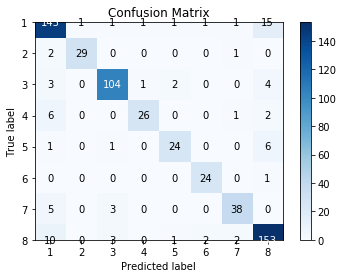

In [51]:
import scikitplot as skplt
plt.figure()
skplt.metrics.plot_confusion_matrix(y_pred=y_pred, y_true=y_test)
plt.show()

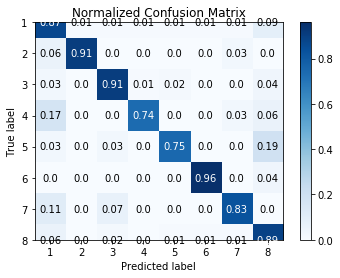

In [52]:
skplt.metrics.plot_confusion_matrix(y_pred=y_pred, y_true=y_test, normalize=True)

### 7d)- For multi-label data

In [0]:
def multilabel_message2(model, doc):
    doc_list = sentence_tokenizer(doc)
    y_pred = pipeline2.predict(doc_list)
    # Remove double class predictions
    y_pred = list(set(y_pred))
    tags = [dict_classes[i] for i in y_pred]
    # Remove `misc` tag if the list contains other tags as well.
    if len(tags) > 1 and dict_classes[8] in tags:
        del tags[tags.index(dict_classes[8])]
    print('{:>30} | {}'.format('['+'] ['.join(tags)+']', doc))

### 7e)- Out of Sample Data checking

In [54]:
multilabel_message2(pipeline2, 'My alarm clock was not set properly. I come to the office asap.')
multilabel_message2(pipeline2, 'It is my scheduled day off, see you on Tuesday.')
multilabel_message2(pipeline2, 'Not feeling well today, I stay home and work from here.')
multilabel_message2(pipeline2, 'I work at home on Tuesday.')
multilabel_message2(pipeline2, 'This morning I have a meeting at ACME.')
multilabel_message2(pipeline2, 'I\'m off, see you tomorrow.')
multilabel_message2(pipeline2, 'Get well soon!')
multilabel_message2(pipeline2, 'I\'m away for a long lunch between 12:00 and 15:30')
multilabel_message2(pipeline2, 'I\'ve an appointment at 12:00 at the physiotherapy.')

                  [late/early] | My alarm clock was not set properly. I come to the office asap.
        [holidays] [in office] | It is my scheduled day off, see you on Tuesday.
           [home office] [ill] | Not feeling well today, I stay home and work from here.
                 [home office] | I work at home on Tuesday.
                    [business] | This morning I have a meeting at ACME.
        [holidays] [in office] | I'm off, see you tomorrow.
               [miscellanious] | Get well soon!
                  [late/early] | I'm away for a long lunch between 12:00 and 15:30
                     [med app] | I've an appointment at 12:00 at the physiotherapy.


# 8)- GridSearchCV

Long computing time !

In [0]:
steps = [('vectorizer', CountVectorizer()),
         ('transformer', TfidfTransformer()),
         ('classifier', SVC(kernel='linear', random_state=1))]
pipeline3 = Pipeline(steps)

In [0]:
params = {
    'vectorizer__tokenizer': [None, nltk.tokenize.word_tokenize],
    'vectorizer__analyzer': ['word', stemmed, lemma],
    'vectorizer__stop_words': [None, nltk.corpus.stopwords.words('english'), 'english'],
    'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3)],
    'vectorizer__preprocessor': [None, mask_all, mask_integers, mask_times, mask_emojis],
    'classifier__C': np.logspace(-2, 2, 5),
    'classifier__gamma': np.logspace(-5, 3, 9)
}

In [0]:
%%time
gs = GridSearchCV(pipeline3, params, n_jobs=-1,verbose=5)
gs.fit(X_train, y_train)

In [0]:
print(gs.best_params_)
y_pred = gs.predict(X_test)
print(classification_report(y_pred=y_pred, y_true=y_test))
print('Score on the test set: {:.2f}'.format(gs.score(X_test, y_test)))

# 9)-Multi label predictions with sentence tokenization and ensembles

- Creating multiple pipeline and then choose best out of them all. 

- Concept of ensemble learning means using multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms alone.

### 9.1)- Creating Pipelines

In [57]:
steps = [('vectorizer', CountVectorizer()),
         ('classifier', SVC(kernel='linear', C=1, probability=True, random_state=1))]
pipeline4 = train_and_test(steps, X_train, X_test, y_train, y_test)
          
steps = [('vectorizer', CountVectorizer()),
         ('transformer', TfidfTransformer()),
         ('classifier', SVC(kernel='linear', C=1, probability=True, random_state=1))]
pipeline5 = train_and_test(steps, X_train, X_test, y_train, y_test)

steps = [('vectorizer', CountVectorizer(analyzer=stemmed)),
         ('transformer', TfidfTransformer()),
         ('classifier', SVC(kernel='linear', C=1, probability=True, random_state=1))]
pipeline6 = train_and_test(steps, X_train, X_test, y_train, y_test)

steps = [('vectorizer', CountVectorizer(analyzer=stemmed, preprocessor=mask_all, ngram_range=(1,3), stop_words='english')),
         ('transformer', TfidfTransformer()),
         ('classifier', SVC(kernel='linear', C=1, probability=True, random_state=1))]
pipeline7 = train_and_test(steps, X_train, X_test, y_train, y_test)

steps = [('vectorizer', CountVectorizer(analyzer=stemmed, preprocessor=mask_all, ngram_range=(1,2))),
         ('transformer', TfidfTransformer()),
         ('classifier', SVC(kernel='linear', C=1, probability=True, random_state=1))]
pipeline8 = train_and_test(steps, X_train, X_test, y_train, y_test)

steps = [('vectorizer', CountVectorizer(preprocessor=mask_all, stop_words='english')),
         ('transformer', TfidfTransformer()),
         ('classifier', SVC(kernel='linear', C=1, probability=True, random_state=1))]
pipeline9 = train_and_test(steps, X_train, X_test, y_train, y_test)

10 fold Cross Validation Score: <0.81, 0.87>; µ=0.85
Score on test set: 0.84
10 fold Cross Validation Score: <0.83, 0.88>; µ=0.86
Score on test set: 0.86
10 fold Cross Validation Score: <0.83, 0.89>; µ=0.86
Score on test set: 0.87
10 fold Cross Validation Score: <0.83, 0.89>; µ=0.86
Score on test set: 0.87
10 fold Cross Validation Score: <0.83, 0.89>; µ=0.86
Score on test set: 0.87
10 fold Cross Validation Score: <0.80, 0.89>; µ=0.83
Score on test set: 0.83


In [0]:
models = [pipeline4, pipeline5, pipeline6, pipeline7, pipeline8, pipeline9]

### 9.2)- Helper Functions for ensemble learning

In [0]:
def ensemble_predict(models, doc):
    y_pred_list = []
    for model in models:
        # Computes a probability vector for every model
        y_pred_list.append(model.predict_proba([doc]))
    # Stack all vectors to a 2D matrix
    y_pred_mat = np.vstack(y_pred_list)
    # Sum all predictions and take the argmax as your final prediction
    y_pred = np.sum(y_pred_mat, axis=0)
    y_pred = np.argmax(y_pred) + 1
    return y_pred

def multilabel4_tag(models, doc):
    doc_list = sentence_tokenizer(doc)
    y_pred = [ensemble_predict(models, token) for token in doc_list]
    # Remove double class predictions
    y_pred = list(set(y_pred))
    tags = [dict_classes[i] for i in y_pred]
    # Remove `misc` tag if the list contains other tags as well.
    if len(tags) > 1 and dict_classes[8] in tags:
        del tags[tags.index(dict_classes[8])]
    print('{:>30} | {}'.format('['+'] ['.join(tags)+']', doc))

### 9.3)- results

In [0]:
y_pred_m = np.vstack(y_pred_list)

In [61]:
y_pred_m

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [62]:
np.sum(y_pred_m, axis=0)

array([122,  31, 115,  19,   7,  22,  25,  88])

In [63]:
multilabel4_tag(models, 'My alarm clock was not set properly. I come to the office asap.')
multilabel4_tag(models, 'It is my scheduled day off, see you on Tuesday.')
multilabel4_tag(models, 'Not feeling well today, I stay home and work from here.')
multilabel4_tag(models, 'I work at home on Tuesday.')
multilabel4_tag(models, 'This morning I have a meeting at ACME.')
multilabel4_tag(models, 'I\'m off, see you tomorrow.')
multilabel4_tag(models, 'Get well soon!')
multilabel4_tag(models, 'I\'m away for a long lunch between 12:00 and 15:30')
multilabel4_tag(models, 'I\'ve an appointment at 12:00 at the physiotherapy.')

                  [late/early] | My alarm clock was not set properly. I come to the office asap.
        [holidays] [in office] | It is my scheduled day off, see you on Tuesday.
           [home office] [ill] | Not feeling well today, I stay home and work from here.
                 [home office] | I work at home on Tuesday.
                    [business] | This morning I have a meeting at ACME.
        [holidays] [in office] | I'm off, see you tomorrow.
               [miscellanious] | Get well soon!
                  [late/early] | I'm away for a long lunch between 12:00 and 15:30
                     [med app] | I've an appointment at 12:00 at the physiotherapy.


In [0]:
# for prediction

y_pred = [ensemble_predict(models, X_test.iloc[i]) for i in range(len(X_test))]

In [65]:
y_pred[:5]

[7, 1, 3, 7, 2]

In [66]:
y_test[:5]

298     7
977     1
1308    3
571     7
77      2
Name: class, dtype: uint8

In [67]:
accuracy=accuracy_score(y_pred=y_pred, y_true=y_test)
accuracy

0.8792270531400966

In [68]:
print(classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           1       0.87      0.84      0.86       166
           2       0.85      0.91      0.88        32
           3       0.94      0.89      0.91       114
           4       0.83      0.86      0.85        35
           5       0.84      0.84      0.84        32
           6       0.96      0.92      0.94        25
           7       0.83      0.83      0.83        46
           8       0.88      0.92      0.90       171

    accuracy                           0.88       621
   macro avg       0.87      0.88      0.88       621
weighted avg       0.88      0.88      0.88       621



In [69]:
cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
cm

array([[140,   1,   2,   4,   1,   0,   2,  16],
       [  2,  29,   0,   0,   0,   0,   1,   0],
       [  3,   0, 102,   2,   3,   1,   1,   2],
       [  2,   2,   0,  30,   0,   0,   1,   0],
       [  1,   1,   1,   0,  27,   0,   0,   2],
       [  0,   0,   0,   0,   0,  23,   1,   1],
       [  4,   1,   2,   0,   0,   0,  38,   1],
       [  9,   0,   2,   0,   1,   0,   2, 157]])

<Figure size 432x288 with 0 Axes>

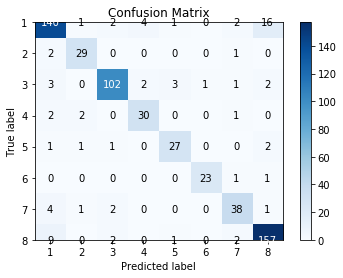

In [70]:
plt.figure()
skplt.metrics.plot_confusion_matrix(y_pred=y_pred, y_true=y_test)
plt.show()

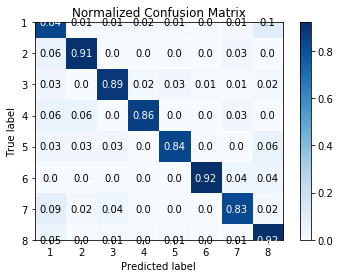

In [71]:
skplt.metrics.plot_confusion_matrix(y_pred=y_pred, y_true=y_test, normalize=True)